## RNN时间序列预测

    1、基本方法：
        1.1 加载时间序列数据。
        1.2 生成训练数据，x的维度为【batch_size,seq_len,word_vector】，y的维度为【batch_size,1】
        1.3 比如在我们的例子中，通过sin函数或者股票的收盘价去预测下一时刻的值，假设batch_size为10，
           那么，我们通过看5天预测一天，x维度就是【10,5,1】。一个seq就是5天的收盘件，最后是1因为
           每天的收盘价都只用1个维度的数据表示。
        1.4 预测，预测有两套方案，假设有100天数据，seq长度为5，往后预测一天：
           1.4.1 方案一：我们利用真实的5天数据，去预测后一天的数据。
           1.4.2 方案二：除了第一次利用5天真实的数据，之后我们都把预测数据放在seq末尾，并剔除第一天，
                    以此预测。
            

## 加载数据

    1、加载股票数据和sin数据
    2、定义获取训练数据和数据归一化的方法

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [137]:
'''
股票数据
'''
raw_data=pd.read_csv('data/all_stock_data.csv')

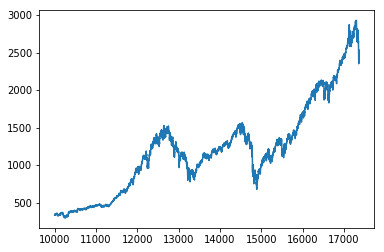

In [136]:
plt.plot(raw_data.loc[10000:,'Close'])

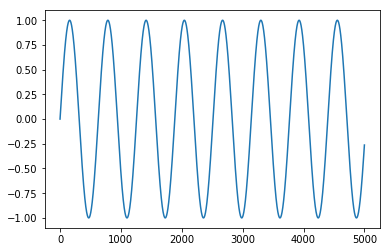

In [138]:
'''
sin数据
'''
x=np.asarray(range(0,5001))/100
y=np.asarray([math.sin(aa) for aa in x])
plt.plot(y)

In [140]:
'''
获取训练数据
'''
def get_train_test(y,seq_len=10,split_per=0.8):
    x_final=[]
    y_final=[]
    window_cnt=int(len(y)/seq_len)
    for i in range(window_cnt):
        x_final.append(y[i*seq_len:(i+1)*seq_len])
        y_final.append(y[(i+1)*seq_len])
    x_final=np.asarray(x_final)
    y_final=np.asarray(y_final)
    
    
    train_len=int(0.8*len(x_final))
    
    x_final_train=np.asarray(x_final[:train_len])
    x_final_train=np.reshape(x_final_train,(x_final_train.shape[0],x_final_train.shape[1],1))
    y_final_train=np.asarray(y_final[:train_len])
    y_final_train=np.reshape(y_final_train,(y_final_train.shape[0],1))
    
    x_final_test=np.asarray(x_final[train_len:])
    x_final_test=np.reshape(x_final_test,(x_final_test.shape[0],x_final_test.shape[1],1))
    y_final_test=np.asarray(y_final[train_len:])
    y_final_test=np.reshape(y_final_test,(y_final_test.shape[0],1))
    
    print(x_final_train.shape,y_final_train.shape)
    print(x_final_test.shape,y_final_test.shape)
    
    return [x_final_train,y_final_train,x_final_test,y_final_test]

'''
数据归一化：min-max归一
'''
def nor_data(y,way='min_max'):
    y_min=min(y)
    y_max=max(y)
    y=(np.asarray(y)-y_min)/(y_max-y_min)
    return y




In [120]:
data_2017=raw_data.loc[10000:16000,:]
y_close=data_2017['Close'].tolist()
y_close=nor_data(y_close)
result=get_train_test(y_close)

(480, 10, 1) (480, 1)
(120, 10, 1) (120, 1)


In [121]:
train=result[0]
label=result[1]
train[1],label[0]

(array([[0.0280015 ],
        [0.02800858],
        [0.03174917],
        [0.03234316],
        [0.03041982],
        [0.0298117 ],
        [0.02626908],
        [0.02782473],
        [0.03018647],
        [0.02906924]]), array([0.0280015]))

In [122]:
aa=[0,1,2,3,4]
aa[2:4]
aa[4]

4

## 构建模型

    1、加载model模型，训练
    2、预测
 

In [123]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense

In [221]:
'''
构建简单的lstm模型
'''
seq_len=10

def build_model():
    model=Sequential()
    model.add(LSTM(units=100,input_shape=(seq_len,1),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100,return_sequences=True))
    model.add(LSTM(units=100,return_sequences=False))
    model.add(Dense(1,activation='linear'))
    model.compile(loss='mse',optimizer='adam',metrics=['mae'])
    return model

In [228]:
'''
训练
'''
def train_model(model,y_org):
    result=get_train_test(y_org,seq_len=seq_len)
    x_train=result[0]
    y_train=result[1]
    model.fit(x_train,y_train,validation_data=(result[2],result[3]),epochs=20,batch_size=10,shuffle=False)
    return model

In [229]:
'''
预测:每次用真实的数据预测后面的数据
'''
def my_predict(y_pred,model):
    predict_input=[]
    for i in range(len(y_pred)-seq_len):
        temp=y_pred[i:i+seq_len]
        predict_input.append(temp)
    predict_input=np.asarray(predict_input)
    # 预测时候所用的格式也必须和训练时候一样（batch_size,seq_len,.word_vector）
    # 只不过单个预测的时候，batch_size设置为1
    predict_input=np.reshape(predict_input,(predict_input.shape[0],predict_input.shape[1],1))
    final_pred_result=model.predict_on_batch(predict_input)
    return final_pred_result

'''
预测：除了第一次用真实数据外，后面都用预测出来的值作为输入
'''
def my_predict_2(y_pred,model):
    predict_input=[]
    final_result=[]
    y_pred=list(y_pred)
    for i in range(len(y_pred)-seq_len):
        if i==0:
            temp=y_pred[i:i+seq_len]
            final_result=y_pred[i:i+seq_len]
        else:
            temp.append(temp_pred)
            temp.pop(0)
#             print(temp)
            
        temp_in=np.asarray(temp)
        temp_in=np.reshape(temp_in,(1,temp_in.shape[0],1))
        temp_pred=model.predict(temp_in)
        temp_pred=temp_pred[0][0]
        final_result.append(temp_pred)
    return final_result

In [230]:
'''
流水线
'''
def pipline(y_org):
    # 建立模型
    model=build_model()
    # 获得原始数据
    y_org=y_org
    # 训练模型
    model=train_model(model,y_org)
    # 预测
    pre_result=my_predict_2(y_org,model)
    # 绘图
    plt.figure(figsize=(5,5))
    plt.plot(y_org)
    plt.plot(pre_result)
    
#     return pre_result

(480, 10, 1) (480, 1)
(120, 10, 1) (120, 1)
Train on 480 samples, validate on 120 samples
Epoch 1/20
480/480 [==============================] - 3s 7ms/step - loss: 0.0024 - mean_absolute_error: 0.0372 - val_loss: 0.0053 - val_mean_absolute_error: 0.0586
Epoch 2/20
480/480 [==============================] - 1s 1ms/step - loss: 0.0228 - mean_absolute_error: 0.1252 - val_loss: 0.0252 - val_mean_absolute_error: 0.1367
Epoch 3/20
480/480 [==============================] - 1s 1ms/step - loss: 0.0668 - mean_absolute_error: 0.2160 - val_loss: 0.0136 - val_mean_absolute_error: 0.1038
Epoch 4/20
480/480 [==============================] - 1s 1ms/step - loss: 0.0159 - mean_absolute_error: 0.1096 - val_loss: 0.0068 - val_mean_absolute_error: 0.0780
Epoch 5/20
480/480 [==============================] - 1s 1ms/step - loss: 0.0108 - mean_absolute_error: 0.0849 - val_loss: 0.0038 - val_mean_absolute_error: 0.0583
Epoch 6/20
480/480 [==============================] - 1s 1ms/step - loss: 0.0074 - mean_ab

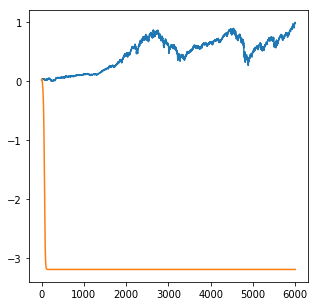

In [231]:
result=pipline(y_close)

## 问题：

    1、突然想起来这个是和我之前做件量预测遇到的问题一样：
        1.1 即，利用预测出来的值再去做预测时，往往会得到特别糟糕的答案。
    
    2、尝试使用另一种模型构建的方式
    